In [1]:
#load libraries
import numpy as np
import math
from math import sqrt
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean
from scipy.stats import norm, lognorm
import seaborn as sns
sns.set()
sns.set_style('white')
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance, Voronoi, voronoi_plot_2d, ConvexHull, Delaunay
from collections import defaultdict
import itertools
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random
import sys
from itertools import combinations 
import time
from scipy import stats
from sklearn.svm import SVC # "Support vector classifier"
import sobol_seq
from mpl_toolkits import mplot3d
import open3d
import os,glob

In [2]:
def js_divergence_scipy(hist1,hist2):
    #square distance to find divergence, use log2
    return (distance.jensenshannon(hist1, hist2, base=2))**2

In [3]:
def nearest_neighbors(values, all_values, nbr_neighbors=1):
    nn = NearestNeighbors(nbr_neighbors, metric='euclidean', algorithm='kd_tree').fit(all_values)
    dists, idxs = nn.kneighbors(values)
    return idxs

In [4]:
def golden(n,d=2):
    g = 1.32471795724474602596 
    
    alpha = np.zeros(d) 
    for j in range(d): 
        alpha[j] = pow(1/g,j+1) %1 
    
    z = np.zeros((n, d)) 
    seed=0.5
    for i in range(n): 
        z[i] = (seed + alpha*(i+1)) %1 
    
    return z

In [18]:
#load mtex and file data
coords = np.loadtxt('Data Files/EBSD Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', usecols=(3,4), skiprows=17)
raw_data = np.loadtxt('Data Files/EBSD Raw Data FZ/AZ31B Ecomp 10e0 Int_3 raw1 FZ.txt')
# mtex_angles = np.loadtxt('Data Files/euler_angles_fz.txt')
# #change raw data to mtex FZ angles
# raw_data[:,0:3]=mtex_angles
#slice data
angles = np.degrees(raw_data[:,0:3])
phi1=angles[:,0]
Phi=angles[:,1]
phi2=angles[:,2]
#create multidimensional histogram
q, edges = np.histogramdd(angles, bins = (10, 10, 10))
#convert q to a 1D probability vector
q=(q.flatten())/np.sum(q)

In [15]:
# #orientation -> rgb colormap
# new_cmap=np.copy(raw_data[:,0:3])
# #normalize
# new_cmap[:,0]=new_cmap[:,0]/360
# new_cmap[:,1]=new_cmap[:,1]/90
# new_cmap[:,2]=new_cmap[:,2]/360

In [6]:
# sample(len(raw_data),'golden')

In [22]:
# plt.ylim(0, np.amax(q))
# plt.bar(np.arange(len(q)),q, width=10)

# size=10000
# percent=sqrt(size/len(raw_data))
# row_list=[]
# for index in range(0,len(raw_data)):
#     if (raw_data[index,3]<=int((110*percent))) and (raw_data[index,4]<=int((110*percent))):
#         row_list.append(raw_data[index,0:3])
#     else:
#         continue

# row_tuple=tuple(row_list)
# sliced_raw_data=np.vstack(row_tuple)
# print(sliced_raw_data.shape)
        
# angles = np.degrees(sliced_raw_data[:,0:3])
# phi1=angles[:,0]
# Phi=angles[:,1]
# phi2=angles[:,2]

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.set_title('FZ')
# ax.set_xlabel('phi1')
# ax.set_ylabel('Phi')
# ax.set_zlabel('phi2');
# ax.scatter3D(phi1, Phi, phi2);
# ax.view_init(25, 90)

# #create multidimensional histogram
# q, edges = np.histogramdd(angles, bins = (10, 10, 10))
# #convert q to a 1D probability vector
# q=(q.flatten())/np.sum(q)

# plt.ylim(0, np.amax(q))
# plt.bar(np.arange(len(q)),q, width=10)

# sliced_raw_data = raw_data[np.random.choice(raw_data.shape[0], 10000, replace=False), 0:3]
# print(sliced_raw_data.shape)

# angles = np.degrees(sliced_raw_data[:,0:3])
# phi1=angles[:,0]
# Phi=angles[:,1]
# phi2=angles[:,2]

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.set_title('FZ')
# ax.set_xlabel('phi1')
# ax.set_ylabel('Phi')
# ax.set_zlabel('phi2');
# ax.scatter3D(phi1, Phi, phi2);
# ax.view_init(25, 90)

# #create multidimensional histogram
# q, edges = np.histogramdd(angles, bins = (10, 10, 10))
# #convert q to a 1D probability vector
# q=(q.flatten())/np.sum(q)

# plt.ylim(0, np.amax(q))
# plt.bar(np.arange(len(q)),q, width=10)

In [23]:
#define slices
x_min=np.amin(raw_data[:,3])
x_max=np.amax(raw_data[:,3])
y_min=np.amin(raw_data[:,4])
y_max=np.amax(raw_data[:,4])

#window one (bottom left)
raw_data_slice_1 = raw_data[np.where((raw_data[:,3] <= x_max/2) & (raw_data[:,4] <= y_max/2))]

# #window two (bottom right)
raw_data_slice_2 = raw_data[np.where((raw_data[:,3] >= x_max/2) & (raw_data[:,4] <= y_max/2))]
raw_data_slice_2[:,3] -= np.min(raw_data_slice_2[:,3])

# #window three (top left)
raw_data_slice_3 = raw_data[np.where((raw_data[:,3] <= x_max/2) & (raw_data[:,4] >= y_max/2))]
raw_data_slice_3[:,4] -= np.min(raw_data_slice_3[:,4])

# #window four (top right)
raw_data_slice_4 = raw_data[np.where((raw_data[:,3] >= x_max/2) & (raw_data[:,4] >= y_max/2))]
raw_data_slice_4[:,3] -= np.min(raw_data_slice_4[:,3])
raw_data_slice_4[:,4] -= np.min(raw_data_slice_4[:,4])

raw_data_slices=[raw_data_slice_1, raw_data_slice_2, raw_data_slice_3, raw_data_slice_4]

In [24]:
def sample(size,method,hist=True):   
    if method == 'random':
        sliced_raw_data = raw_data[np.random.choice(raw_data.shape[0], size, replace=False), 0:3]
    
    if method == 'square':
        phi = (np.sqrt(5)+1)/2
        ratio = np.sqrt(3)/2 # cos(60°)
        coords = raw_data[:,3:5]
        N = size
        
        N_X = int(np.sqrt(N))
        N_Y = N // N_X
        xv, yv = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')
        square_coords=np.concatenate((xv.reshape(-1,1), yv.reshape(-1,1)), axis=1)
        square_coords[:,0] = square_coords[:,0] * (np.amax(raw_data[:,3]) / np.amax(square_coords[:,0]))
        square_coords[:,1] = square_coords[:,1] * (np.amax(raw_data[:,4]) / np.amax(square_coords[:,1]))
        grid_sample=raw_data[nearest_neighbors(square_coords,coords), 0:3]
        sliced_raw_data=grid_sample[:,0]
        
    if method == 'hex':
        phi = (np.sqrt(5)+1)/2
        ratio = np.sqrt(3)/2 # cos(60°)
        coords = raw_data[:,3:5]
        N = size
        
        N_X = int(np.sqrt(N)/ratio)
        N_Y = N // N_X
        xv, yv = np.meshgrid(np.arange(N_X), np.arange(N_Y), sparse=False, indexing='xy')
        xv = xv * ratio
        xv[::2, :] += ratio/2
        hex_coords=np.concatenate((xv.reshape(-1,1), yv.reshape(-1,1)), axis=1)
        hex_coords[:,0] *= (np.amax(raw_data[:,3]) / np.amax(hex_coords[:,0]))
        hex_coords[:,1] *= (np.amax(raw_data[:,4]) / np.amax(hex_coords[:,1]))
        grid_sample=raw_data[nearest_neighbors(hex_coords,coords), 0:3]
        sliced_raw_data=grid_sample[:,0]
        
    if method == 'sobol':
        coords = raw_data[:,3:5]
        
        sobol = (sobol_seq.i4_sobol_generate(2, size))
        sobol[:,0]*=np.amax(raw_data[:,3])
        sobol[:,1]*=np.amax(raw_data[:,4])
        sobol_sample=raw_data[nearest_neighbors(sobol,coords), 0:3]
        sliced_raw_data=sobol_sample[:,0]
        
    if method == 'gold':
        coords = raw_data[:,3:5]
        
        golden_2D = golden(size)
        golden_2D[:,0]*=np.amax(raw_data[:,3])
        golden_2D[:,1]*=np.amax(raw_data[:,4])
        golden_sample=raw_data[nearest_neighbors(golden_2D,coords), 0:3]
        sliced_raw_data=golden_sample[:,0]
        
    if method == 'window':
        percent=sqrt(size/len(raw_data))
        
#         window_divergences=[]
#         p_list=[]
#         for raw_data_slice_x in raw_data_slices:
#             raw_data_slice=raw_data_slice_x
    
#             row_list=[]
#             for index in range(0,len(raw_data_slice)):
#                 if (raw_data_slice[index,3]<=int((110*percent))) and (raw_data_slice[index,4]<=int((110*percent))):
#                     row_list.append(raw_data_slice[index, 0:3])
#                 else:
#                     continue

#             row_tuple=tuple(row_list)
#             sliced_raw_data_slice=np.vstack(row_tuple)
#             p, edges = np.histogramdd(sliced_raw_data_slice, bins = (10, 10, 10))
#             p=(p.flatten())/np.sum(p)
#             window_divergences.append(js_divergence_scipy(p,q))
#             p_list.append(p)
            
#         #return average JS Divergence
#         if hist==True:
#             return sum(window_divergences)/4
#         else:
#             mean_errors=[]
#             q_copy=np.copy(q)
#             q_copy[np.where(q_copy<0.001)]=0
#             for p in p_list:
#                 p[np.where(p<0.001)]=0
#                 mean_errors.append(np.mean(np.absolute(p-q_copy)))
                
#             return sum(mean_errors)/len(mean_errors)
        
        #Full Window
        row_list=[]
        for index in range(0,len(raw_data)):
            if (raw_data[index,3]<=int((110*percent))) and (raw_data[index,4]<=int((110*percent))):
                row_list.append(raw_data[index,0:3])
            else:
                continue

        row_tuple=tuple(row_list)
        sliced_raw_data=np.vstack(row_tuple)
            
    #create p histogram, normalized so there is no need to rescale
    p, edges = np.histogramdd(sliced_raw_data, bins = (10, 10, 10))
    p=(p.flatten())/np.sum(p)

    if hist==True:
        return js_divergence_scipy(p,q)
    else:
        q_copy=np.copy(q)
        
        #JS Divergence Style
#         p[np.where(q_copy==0)]=0
#         q_copy[np.where(p==0)]=0
        #a small floor
        p[np.where(p<0.001)]=0
        q_copy[np.where(q_copy<0.001)]=0
        
        #mean error
        return np.mean(np.absolute(p-q_copy))

In [25]:
# a=np.array([1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0])
# b=np.array([0,1,0,1,0,0,1,1,1,0,0,0,1,1,1,1,0])
# a[np.where(b==0)]=0
# b[np.where(a==0)]=0
# print(a)
# print(b)

In [60]:
sizes=np.arange(10,len(raw_data),100)
percents=(sizes/len(raw_data))*100

# random_div=np.zeros(len(percents))
# square_div=np.zeros(len(percents))
# hex_div=np.zeros(len(percents))
# sobol_div=np.zeros(len(percents))
# gold_div=np.zeros(len(percents))
window_div=np.zeros(len(percents))

# random_mean=np.zeros(len(percents))
# square_mean=np.zeros(len(percents))
# hex_mean=np.zeros(len(percents))
# sobol_mean=np.zeros(len(percents))
# gold_mean=np.zeros(len(percents))
# window_mean=np.zeros(len(percents))
    
index=0
for x in percents:
#     random_div[index]=sample(sizes[index],'random')
#     square_div[index]=sample(sizes[index],'square')
#     hex_div[index]=sample(sizes[index],'hex')
#     sobol_div[index]=sample(sizes[index],'sobol')
#     gold_div[index]=sample(sizes[index],'gold')
    window_div[index]=sample(sizes[index],'window')
    
#     random_mean[index] = sample(sizes[index],'random',hist=False)
#     square_mean[index] = sample(sizes[index],'square',hist=False)
#     hex_mean[index] = sample(sizes[index],'hex',hist=False)
#     sobol_mean[index] = sample(sizes[index],'sobol',hist=False)
#     gold_mean[index] = sample(sizes[index],'gold',hist=False)
#     window_mean[index] = sample(sizes[index],'window',hist=False)
    
    index+=1

In [26]:
# #FZ
# %store percents
# %store random_div
# %store square_div
# %store hex_div
# %store sobol_div
# %store gold_div
# %store window_div

In [27]:
# #FZ
# %store percents
# %store random_mean
# %store square_mean
# %store hex_mean
# %store sobol_mean
# %store gold_mean
# %store window_mean

In [61]:
%store -r

In [62]:
sizes=np.arange(10,21900,100)
percents=(sizes/len(raw_data))*100

NameError: name 'percents_2' is not defined

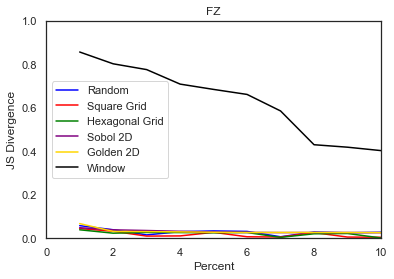

In [34]:
plt.xlim(0,10)
plt.ylim(0,1)
plt.title('FZ')
plt.xlabel('Percent')
plt.ylabel('JS Divergence')
sns.lineplot(percents,random_div,color='blue',label='Random')
sns.lineplot(percents,square_div,color='red',label='Square Grid')
sns.lineplot(percents,hex_div,color='green',label='Hexagonal Grid')
sns.lineplot(percents,sobol_div,color='purple',label='Sobol 2D')
sns.lineplot(percents,gold_div,color='gold',label='Golden 2D')
sns.lineplot(percents,window_div,color='black',label='Window')
sns.lineplot(percents_2,window_div_2,color='blue',label='Window')

In [14]:
#create dataset
path = 'Data Files/EBSD Raw Data'
dataset=[]
#open all files
for filename in glob.glob(os.path.join(path, '*.txt')):
    with open(filename, 'r') as f:
        #remove comments
        for line in f:
            if '#' not in line:
                break
        
        #load to np array and add to dataset
        data=np.loadtxt(filename, usecols=(0,1,2,3,4,8,9))
        dataset.append(data)
        
#get FZ angles
path = 'Data Files/EBSD Raw Data FZ'
FZ_dataset=[]
#open all files
for filename in glob.glob(os.path.join(path, '*.txt')):
    with open(filename, 'r') as f:
        #remove comments
        for line in f:
            if '#' not in line:
                break
        
        #load to np array and add to dataset
        data=np.loadtxt(filename)
        FZ_dataset.append(np.degrees(data))
        
#change raw data angles to mtex angles
for x in range(0,len(dataset)):
    datafile=dataset[x]
    datafile[:,0:3]=FZ_dataset[x]

In [103]:
#how big is each file before pieces are removed?
#do we average files processed differently?
file_size=100000

#number of trials to avg
num_trials=len(dataset)

#number of points to sample
sizes=np.arange(10,11000,100)
# sizes=np.arange(1000,11000,1000)
percents=(sizes/file_size)*100

#six different sampling methods (random, square, hex, sobol, gold, window)
divergences=np.zeros((len(sizes),6))
mean_errors=np.zeros((len(sizes),6))

# for each file
for x in dataset:
    #slice raw data
    raw_data=x
    #slice angles
    angles = raw_data[:,0:3]
    #create multidimensional histogram
    q, edges = np.histogramdd(angles, bins = (10, 10, 10))
    q=(q.flatten())/np.sum(q)

    #divergence for each method    
    random_div=np.zeros(len(percents))
    square_div=np.zeros(len(percents))
    hex_div=np.zeros(len(percents))
    sobol_div=np.zeros(len(percents))
    gold_div=np.zeros(len(percents))
    window_div=np.zeros(len(percents))
    
    #mean error for each method    
    random_meanerr=np.zeros(len(percents))
    square_meanerr=np.zeros(len(percents))
    hex_meanerr=np.zeros(len(percents))
    sobol_meanerr=np.zeros(len(percents))
    gold_meanerr=np.zeros(len(percents))
    window_meanerr=np.zeros(len(percents))

    index=0
    for x in percents:
        #append divergences
        random_div[index]=sample(sizes[index],'random')
        square_div[index]=sample(sizes[index],'square')
        hex_div[index]=sample(sizes[index],'hex')
        sobol_div[index]=sample(sizes[index],'sobol')
        gold_div[index]=sample(sizes[index],'gold')
        window_div[index]=sample(sizes[index],'window')
        
        #append error
        random_meanerr[index] = sample(sizes[index],'random',hist=False)
        square_meanerr[index] = sample(sizes[index],'square',hist=False)
        hex_meanerr[index] = sample(sizes[index],'hex',hist=False)
        sobol_meanerr[index] = sample(sizes[index],'sobol',hist=False)
        gold_meanerr[index] = sample(sizes[index],'gold',hist=False)
        window_meanerr[index] = sample(sizes[index],'window',hist=False)
 
        index+=1

    #add to array
    divergences[:,0]+=random_div
    divergences[:,1]+=square_div
    divergences[:,2]+=hex_div
    divergences[:,3]+=sobol_div
    divergences[:,4]+=gold_div
    divergences[:,5]+=window_div

    mean_errors[:,0]+=random_meanerr
    mean_errors[:,1]+=square_meanerr
    mean_errors[:,2]+=hex_meanerr
    mean_errors[:,3]+=sobol_meanerr
    mean_errors[:,4]+=gold_meanerr
    mean_errors[:,5]+=window_meanerr

#average results        
divergences=divergences/num_trials
mean_errors=mean_errors/num_trials

#slice results
avg_random_div=divergences[:,0]
avg_hex_div=divergences[:,1]
avg_square_div=divergences[:,2]
avg_sobol_div=divergences[:,3]
avg_gold_div=divergences[:,4]
avg_window_div=divergences[:,5]

avg_random_meanerr=mean_errors[:,0]
avg_hex_meanerr=mean_errors[:,1]
avg_square_meanerr=mean_errors[:,2]
avg_sobol_meanerr=mean_errors[:,3]
avg_gold_meanerr=mean_errors[:,4]
avg_window_meanerr=mean_errors[:,5]

In [101]:
#slice raw data
raw_data=dataset[7]
#slice angles
angles = raw_data[:,0:3]
#create multidimensional histogram
q, edges = np.histogramdd(angles, bins = (10, 10, 10))
q=(q.flatten())/np.sum(q)

sample(10000,'random',hist=False)

9.559960183157476e-05

In [106]:
%store avg_random_div
%store avg_hex_div
%store avg_square_div
%store avg_sobol_div
%store avg_gold_div
%store avg_window_div

Stored 'avg_random_div' (ndarray)
Stored 'avg_hex_div' (ndarray)
Stored 'avg_square_div' (ndarray)
Stored 'avg_sobol_div' (ndarray)
Stored 'avg_gold_div' (ndarray)
Stored 'avg_window_div' (ndarray)


In [107]:
%store avg_random_meanerr
%store avg_hex_meanerr
%store avg_square_meanerr
%store avg_sobol_meanerr
%store avg_gold_meanerr
%store avg_window_meanerr

Stored 'avg_random_meanerr' (ndarray)
Stored 'avg_hex_meanerr' (ndarray)
Stored 'avg_square_meanerr' (ndarray)
Stored 'avg_sobol_meanerr' (ndarray)
Stored 'avg_gold_meanerr' (ndarray)
Stored 'avg_window_meanerr' (ndarray)


In [72]:
# avg_random_div_copy=np.copy(avg_random_div)
# avg_hex_div_copy=np.copy(avg_hex_div)
# avg_square_div_copy=np.copy(avg_square_div)
# avg_sobol_div_copy=np.copy(avg_sobol_div)
# avg_gold_div_copy=np.copy(avg_gold_div)
# avg_window_div_copy=np.copy(avg_window_div)
# %store avg_random_div_copy
# %store avg_hex_div_copy
# %store avg_square_div_copy
# %store avg_sobol_div_copy
# %store avg_gold_div_copy
# %store avg_window_div_copy

In [73]:
# avg_random_meanerr_copy=np.copy(avg_random_meanerr)
# avg_hex_meanerr_copy=np.copy(avg_hex_meanerr)
# avg_square_meanerr_copy=np.copy(avg_square_meanerr)
# avg_sobol_meanerr_copy=np.copy(avg_sobol_meanerr)
# avg_gold_meanerr_copy=np.copy(avg_gold_meanerr)
# avg_window_meanerr_copy=np.copy(avg_window_meanerr)
# %store avg_random_meanerr_copy
# %store avg_hex_meanerr_copy
# %store avg_square_meanerr_copy
# %store avg_sobol_meanerr_copy
# %store avg_gold_meanerr_copy
# %store avg_window_meanerr_copy

<AxesSubplot:title={'center':'FZ'}, xlabel='Percent', ylabel='JS Divergence'>

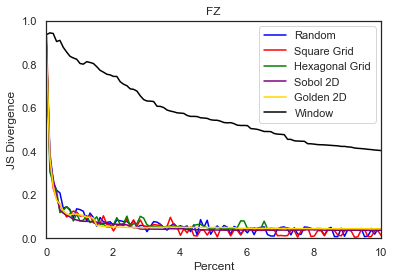

In [104]:
plt.xlim(0,10)
plt.ylim(0,1)
plt.title('FZ')
plt.xlabel('Percent')
plt.ylabel('JS Divergence')
# sns.lineplot(percents_2,avg_random_div_copy,color='blue',label='Random')
# sns.lineplot(percents_2,avg_square_div_copy,color='red',label='Square Grid')
# sns.lineplot(percents_2,avg_hex_div_copy,color='green',label='Hexagonal Grid')
# sns.lineplot(percents_2,avg_sobol_div_copy,color='purple',label='Sobol 2D')
# sns.lineplot(percents_2,avg_gold_div_copy,color='gold',label='Golden 2D')
# sns.lineplot(percents_2,avg_window_div_copy,color='black',label='Window')

sns.lineplot(percents,avg_random_div,color='blue',label='Random')
sns.lineplot(percents,avg_square_div,color='red',label='Square Grid')
sns.lineplot(percents,avg_hex_div,color='green',label='Hexagonal Grid')
sns.lineplot(percents,avg_sobol_div,color='purple',label='Sobol 2D')
sns.lineplot(percents,avg_gold_div,color='gold',label='Golden 2D')
sns.lineplot(percents,avg_window_div,color='black',label='Window')

In [85]:
%store -r

In [88]:
# sizes=np.arange(1000,11000,1000)
sizes=np.arange(1000,11000,1000)
percents=(sizes/file_size)*100

In [91]:
random_meanerr.shape

(110,)

In [95]:
%store percents
%store percents_2

Stored 'percents' (ndarray)
Stored 'percents_2' (ndarray)


<AxesSubplot:title={'center':'Mean Binwise Difference (Error) vs Percent'}, xlabel='Percent', ylabel='Error'>

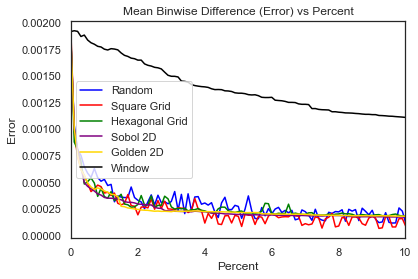

In [105]:
plt.xlim(0,10)
# plt.ylim(0,0.03)
plt.title('Mean Binwise Difference (Error) vs Percent')
plt.xlabel('Percent')
plt.ylabel('Error')
sns.lineplot(percents,avg_random_meanerr,color='blue',label='Random')
sns.lineplot(percents,avg_square_meanerr,color='red',label='Square Grid')
sns.lineplot(percents,avg_hex_meanerr,color='green',label='Hexagonal Grid')
sns.lineplot(percents,avg_sobol_meanerr,color='purple',label='Sobol 2D')
sns.lineplot(percents,avg_gold_meanerr,color='gold',label='Golden 2D')
sns.lineplot(percents,avg_window_meanerr,color='black',label='Window')

# sns.lineplot(percents_2,avg_random_meanerr_copy,color='blue',label='Random')
# sns.lineplot(percents_2,avg_square_meanerr_copy,color='red',label='Square Grid')
# sns.lineplot(percents_2,avg_hex_meanerr_copy,color='green',label='Hexagonal Grid')
# sns.lineplot(percents_2,avg_sobol_meanerr_copy,color='purple',label='Sobol 2D')
# sns.lineplot(percents_2,avg_gold_meanerr_copy,color='gold',label='Golden 2D')
# sns.lineplot(percents_2,avg_window_meanerr_copy,color='black',label='Window')

In [40]:
# # #mean for each method    
# # random_mean=np.zeros(len(percents))
# # square_mean=np.zeros(len(percents))
# # hex_mean=np.zeros(len(percents))
# # sobol_mean=np.zeros(len(percents))
# # gold_mean=np.zeros(len(percents))
# # # window_mean=np.zeros(len(percents))

# # index=0
# # for x in percents:
# #     print(x)
# #     #append mean and variance
# #     random_mean[index] = sample(sizes[index],'random',hist=False)
# #     square_mean[index] = sample(sizes[index],'square',hist=False)
# #     hex_mean[index] = sample(sizes[index],'hex',hist=False)
# #     sobol_mean[index] = sample(sizes[index],'sobol',hist=False)
# #     gold_mean[index] = sample(sizes[index],'gold',hist=False)
# # #     window_mean[index] = sample(sizes[index],'window',hist=False)
        
# #     index+=1

# %store random_mean
# %store square_mean
# %store hex_mean
# %store sobol_mean
# %store gold_mean

# plt.xlim(0, 10)
# plt.ylim(200, 400)
# # plt.ylim(-1000,1000)
# plt.title('Square')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('Mean Distance from Origin')

# #mean, var errorbars
# sns.scatterplot(percents, square_mean, s=100, color="blue", marker="o")
# # plt.errorbar(percents, random_mean, yerr=gm_square_var, fmt='o')

# #actual mean
# plt.axhline(y=actual_mean, color='blue', linestyle='-',label='total mean')

In [39]:
# # #var for each method  
# # random_var=np.zeros((len(percents),3))
# # square_var=np.zeros((len(percents),3))
# # hex_var=np.zeros((len(percents),3))
# # sobol_var=np.zeros((len(percents),3))
# # gold_var=np.zeros((len(percents),3))
# # # window_var=np.zeros((len(percents),3))

# # index=0
# # for x in percents:
# #     print(x)
# #     random_var[index]+=sample(sizes[index],'random')
# #     square_var[index]+=sample(sizes[index],'square')
# #     hex_var[index]+=sample(sizes[index],'hex')
# #     sobol_var[index]+=sample(sizes[index],'sobol')
# #     gold_var[index]+=sample(sizes[index],'gold')
# # #     window_div[index]+=sample(sizes[index],'window')
# #     index+=1

# %store random_var
# %store square_var
# %store hex_var
# %store sobol_var
# %store gold_var

# plt.xlim(0, 10)
# # plt.ylim(200, 400)
# # plt.ylim(-1000,1000)
# plt.title('Random')
# plt.xlabel('Percent of Total Available Data Points')
# plt.ylabel('Variance - cov(z,z)')

# #mean, var errorbars
# # sns.scatterplot(percents, random_mean, s=100, color="blue", marker="o")
# # plt.errorbar(percents, random_mean, yerr=random_var[:,0], fmt='o')
# sns.lineplot(percents, random_var[:,2])

# #actual mean
# # plt.axhline(y=actual_mean, color='blue', linestyle='-',label='total mean')

In [30]:
# point_cloud = open3d.PointCloud()
# point_cloud.points = open3d.Vector3dVector(angles)
# open3d.geometry.compute_point_cloud_mean_and_covariance(point_cloud)

#     else:
#         sliced_angles=sliced_raw_data[:,0:3]
#         sliced_angles=np.degrees(sliced_angles)
#         point_cloud = open3d.PointCloud()
#         point_cloud.points = open3d.Vector3dVector(sliced_angles)
#         cloud_mean, cloud_covar_matrix = open3d.geometry.compute_point_cloud_mean_and_covariance(point_cloud)
# #         return (distance.euclidean(origin,cloud_mean)), np.array([cloud_covar_matrix[0,0], cloud_covar_matrix[1,1], cloud_covar_matrix[2,2]])
# #         return (distance.euclidean(origin,cloud_mean))
#         return np.array([cloud_covar_matrix[0,0], cloud_covar_matrix[1,1], cloud_covar_matrix[2,2]])

In [8]:
# #is lots of zeros impacting?
# origin=np.array([0,0,0])

In [28]:
# plt.xlim(0,10)
# plt.ylim(0.015,0.03)
# plt.title('Mean Error vs. Percent')
# plt.xlabel('Percent')
# plt.ylabel('Mean Error')
# plt.axhline(actual_mean,color='pink',label='Actual Mean')
# sns.lineplot(percents,random_mean,color='blue',label='Random')
# sns.lineplot(percents,square_mean,color='red',label='Square Grid')
# sns.lineplot(percents,hex_mean,color='green',label='Hexagonal Grid')
# sns.lineplot(percents,sobol_mean,color='purple',label='Sobol 2D')
# sns.lineplot(percents,gold_mean,color='gold',label='Golden 2D')
# sns.lineplot(percents,window_mean,color='black',label='Window')